# Non-Negativ Matrix Factorization Model on 1-gram Tokens

In [1]:
import warnings
warnings.simplefilter('ignore')
from pathlib import Path
import sys
sys.path.append(str(Path.cwd().parent))
from src.models.nmfTopicModeler import nmfTopicModeler

import pandas as pd
import numpy as np
import seaborn as sns

import pyLDAvis
import pyLDAvis.sklearn

### Load dataset

In [2]:
path_to_data = Path('../data')
df = pd.read_csv(path_to_data / 'processed' /'tokenized1gram_data.csv', converters={'tokenized': eval, 'tokenized_mults': eval, 'tokenized_mults_extr': eval})

## Fit model for cleaned token set (excl. extra stops)

In [3]:
topic_mdl = nmfTopicModeler(n_components = 8, max_iter = 10000)
topic_mdl.fit(df['tokenized_mults_extr'])

pyLDAvis.enable_notebook()
vis_nmf = pyLDAvis.sklearn.prepare(topic_mdl.mdl,\
                                   topic_mdl.doc_term_matrix, topic_mdl.vectors)
vis_nmf

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.032571  0.099083       1        1  15.287240
2      0.045876  0.070496       2        1  14.199424
7      0.094575 -0.077144       3        1  13.668674
0      0.043915  0.012908       4        1  12.657535
6     -0.096280 -0.086007       5        1  11.955627
5      0.134845  0.168193       6        1  11.606024
4     -0.282578  0.018530       7        1  11.347647
1      0.092217 -0.206060       8        1   9.277830, topic_info=            Term       Freq      Total Category  logprob  loglift
654        csekk  47.000000  47.000000  Default  30.0000  30.0000
1877  hozzájárul  26.000000  26.000000  Default  29.0000  29.0000
2924       levél  37.000000  37.000000  Default  28.0000  28.0000
339         bank  21.000000  21.000000  Default  27.0000  27.0000
2150      jelszó  20.000000  20.000000  Default  26.0000  26.0000
...          ...        ...        ...      ...      ...      ...
5298      összeg   4.401948  32.520324   Topic8  -5.1741   0.3777
317    azonosító   3.205508  18.799102   Topic8  -5.4913   0.6086
4708        utal   3.454763  28.820346   Topic8  -5.4164   0.2562
47            ad   3.461285  32.749114   Topic8  -5.4145   0.1303
526    biztosító   2.809162  11.338450   Topic8  -5.6233   0.9822

[616 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
2         5  1.404891            157es
12        8  1.952378  2400dunaújváros
47        1  0.183211               ad
47        2  0.091606               ad
47        3  0.061070               ad
...     ...       ...              ...
5357      6  0.122215           ügyfél
5361      7  0.963261     ügyfélprofil
5362      2  0.323222  ügyfélszolgálat
5362      5  0.484832  ügyfélszolgálat
5369      7  1.030315           ügynök

[967 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 8, 1, 7, 6, 5, 2])

#### Show topic key words

In [4]:
topic_mdl.show_topics(8)

['tud szerződés név információ meghatalmazás ért telefon biztosítás',
 'bank csoportos megbízás levon von beszedési levonás terhelés',
 'díj évforduló éves biztosítás szerződés fizet következő negyedéves',
 'levél kap küld biztosítás email hátralék néz cím',
 'hozzájárul ajánlat adat elérhetőség akció megkeres szerződés álló',
 'csekk befizet fizet küld kap negyedév tud negyedéves',
 'jelszó tud cím email felület online felhasználónév regisztráció',
 'utal összeg közlemény lát számlaszám pénz utalás ír']

* 0 - adatvédelmi okokból csak a szerződőnek info 
* 1 - csoportos beszedés nem működött  
* 2 - évfordulóval kapcsolatos díjváltozást nem érti
* 3 - levél vagy email a hátralékról (inter, díjfelszólító)
* 4 - marketing hozzájárulás
* 5 - csekkes befizetés probléma
* 6 - online irányba terelés
* 7 - egyedi utalásos probléma

#### Show main topic distribution

In [4]:
# Drop administrative topics 
topic_mdl.drop_topics(drop_list = [0,4,6])

Dropped topics 0,4,6


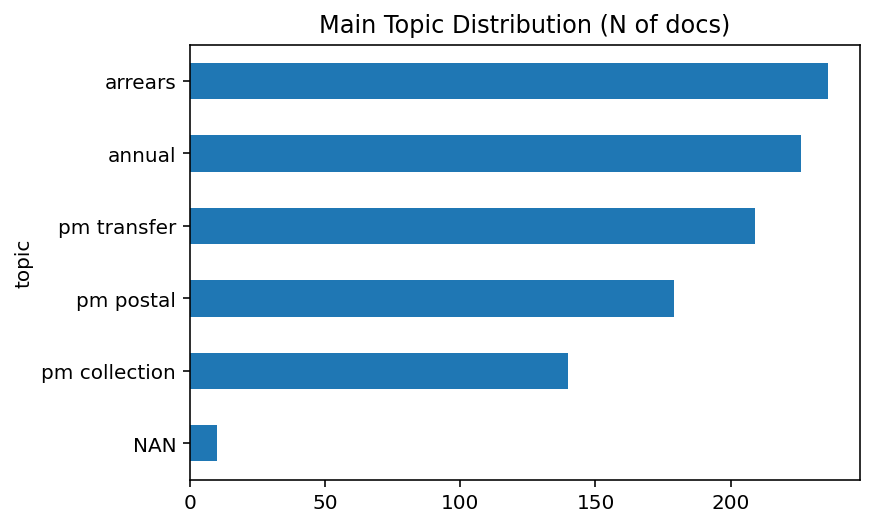

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

doc_main_topic, main_topic = topic_mdl.get_main_topic(topic_names = ['pm collection', 'annual', 'arrears', 'pm postal', 'pm transfer', 'NAN'],\
                                    threshold = 0.005)
main_topic['count'][::-1].plot.barh(title = 'Main Topic Distribution (N of docs)');

#### Show topic frequency

In [6]:
topic_mdl.get_topic_frequency(topic_names =\
['pm collection', 'annual', 'arrears', 'pm postal', 'pm direct'],\
                              threshold = 0.015)

,count,pct
arrears,518,0.257840
annual,486,0.241911
pm direct,414,0.206073
pm postal,355,0.176705
pm collection,236,0.117471


#### Show multi-topic distribution

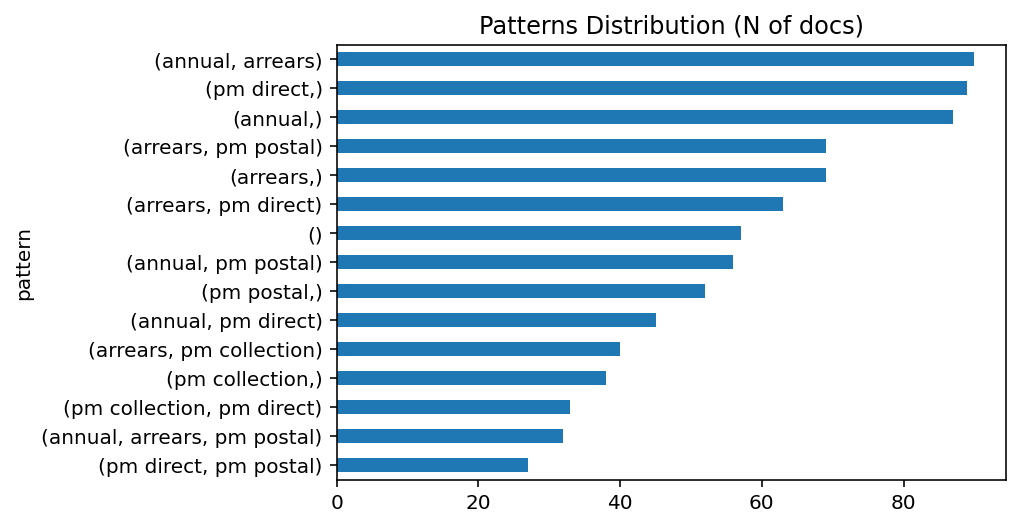

In [7]:
doc_pattern, topic_patterns = topic_mdl.get_topic_patterns(topic_names = ['pm collection', 'annual', 'arrears', 'pm postal', 'pm direct'],\
                                    threshold = 0.02)

topic_patterns = topic_patterns.iloc[0:15, 0][::-1]
topic_patterns.plot.barh(title = 'Patterns Distribution (N of docs)');

In [33]:
# Export patterns for inspection
#df_pattern = df.join(pattern_by_doc)
#df_pattern.loc[:, ['file_name', 'text', 'pattern']].to_csv(path_to_data / 'processed' / '1gram_pattern_inspect.csv')

## Fit submodels

In [8]:
doc_sub_patterns, sub_patterns_mains, sub_patterns_freq = topic_mdl.fit_submodels(df['tokenized_mults_extr'], doc_pattern, topn_topics=20, n_tokens=50,\
                     n_topics=5, n_words=8, threshold = 0.02)

In [10]:
# from matplotlib import pyplot as plt
# f, a = plt.subplots(6, 1, figsize=(10, 30))
# for idx, level in enumerate(sub_patterns_mains.index.levels[0]):
#     sub_patterns_mains.loc[level, 'count'][::-1].plot(kind='barh', title = level, ax=a[idx])

#### Derive main topic from patterns

In [11]:
# Export results for inspection
derived = df.join(doc_main_topic)[['file_name', 'text', 'topic']].rename(columns={'topic': 'main_topic'})
derived = derived.join(doc_sub_patterns.reset_index(level = 0)).rename(columns={'level_0': 'pattern', 'topic': 'sub_topic'})
derived['main_topic_derived'] = np.where(derived['pattern'].str.contains('arrears')==True, 'arrears',\
                                np.where(derived['pattern'].str.contains('annual')==True, 'annual', derived['pattern']))
derived.to_csv(path_to_data / 'processed' / 'subtopics_inspect.csv')

In [12]:
derived.groupby('main_topic_derived').size().reset_index()\
            .rename(columns={0: 'count'}).sort_values('count', ascending=False)

,main_topic_derived,count
8,arrears,401
7,annual,218
4,"('pm direct',)",89
6,(),57
5,"('pm postal',)",52
2,"('pm collection',)",38
0,"('pm collection', 'pm direct')",33
3,"('pm direct', 'pm postal')",27
1,"('pm collection', 'pm postal')",14


In [14]:
sub_patterns_freq.to_csv(path_to_data / 'processed' / 'subtopics_freqs.csv')